In [1]:
%pip install ydata-profiling prince imbalanced-learn matplotlib scikit-learn joblib xgboost --upgrade

  Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.0-cp311-cp311-win_amd64.whl.metadata (11 kB)
Using cached matplotlib-3.10.0-cp311-cp311-win_amd64.whl (8.0 MB)
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 1.9 MB/s eta 0:00:39
   ---------------------------------------- 0.8/72.0 MB 1.7 MB/s eta 0:00:43
    --------------------------------------- 1.3/72.0 MB 1.6 MB/s eta 0:00:46
    --------------------------------------- 1.6/72.0 MB 1.6 MB/s eta 0:00:45
   - -------------------------------------- 1.8/72.0 MB 1.6 MB/s eta 0:00:45
   - -------------------------------------- 1.8/72.0 MB 1.6 MB/s eta 0:00:45
   - -------------------------------------- 1.8/72.0 MB 1.6 MB/s eta 0:00:45
   - -------------------------------------- 1.8/72.0 MB 1.6 MB/s eta 0:00:45
   - ---------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.5.2 which is incompatible.
pandas-profiling 3.2.0 requires visions[type_image_path]==0.7.4, but you have visions 0.7.6 which is incompatible.
tensorflow-intel 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.4 which is incompatible.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.15.0 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import math
import time
import random
import datetime
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, cross_val_score
from xgboost import XGBClassifier
import warnings
import joblib
import os
warnings.filterwarnings('ignore')

In [3]:
# Check available Matplotlib styles
print("Available Matplotlib styles:", plt.style.available)
if 'seaborn-v0_8-whitegrid' not in plt.style.available:
    plt.style.use('classic')
    print("Using fallback style: 'classic' since 'seaborn-v0_8-whitegrid' is unavailable.")

Available Matplotlib styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [4]:
# Load the dataset from public URL or local path
#url = 'https://raw.githubusercontent.com/JamieDuane/SC5010_IBM_Data_Analysis/main/data/WA_Fn-UseC_-HR-Employee-Attrition.csv'
try:
    #df = pd.read_csv(url)
    df = pd.read_csv(r"C:\Users\name\Downloads\Employee_Attrition_Prediction\WA_Fn-UseC_-HR-Employee-Attrition.csv")
    print("Original DataFrame shape:", df.shape)
    display(df.head())
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Original DataFrame shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [5]:
# Generate Profiling Report
try:
    profile = ProfileReport(df, title="Employee Attrition Profiling Report", explorative=True)
    profile.to_file("attrition_report.html")
    print("Profiling report saved as 'attrition_report.html'")
except Exception as e:
    print(f"Error generating profiling report: {e}")
    raise

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:00<00:00, 44.15it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling report saved as 'attrition_report.html'


In [6]:
# Verify column names
print("Column names in DataFrame:", df.columns.tolist())

# Check if 'Attrition' exists
if 'Attrition' not in df.columns:
    raise KeyError("Column 'Attrition' not found in DataFrame. Check dataset.")

# Encode target (Attrition: Yes/No to 1/0)
le = LabelEncoder()
df['Attrition'] = le.fit_transform(df['Attrition'])
y = df['Attrition']

# Features: Drop irrelevant/constant columns
drop_cols = ['Attrition', 'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber', 'PerformanceRating', 'StockOptionLevel']
X = df.drop(drop_cols, axis=1)
print("X shape after dropping irrelevant columns:", X.shape)  # Should be (1470, 28)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# Preprocessor: OneHot for categoricals, StandardScaler for numericals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

# Apply preprocessing
try:
    X_processed = preprocessor.fit_transform(X)
    print("X_processed shape after scaling and one-hot encoding:", X_processed.shape)
except Exception as e:
    print(f"Error in preprocessing: {e}")
    raise

Column names in DataFrame: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
X shape after dropping irrelevant columns: (1470, 28)
Categorical columns: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Numerical columns: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome'

X_pca shape after PCA (reduced dimensions): (1470, 27)


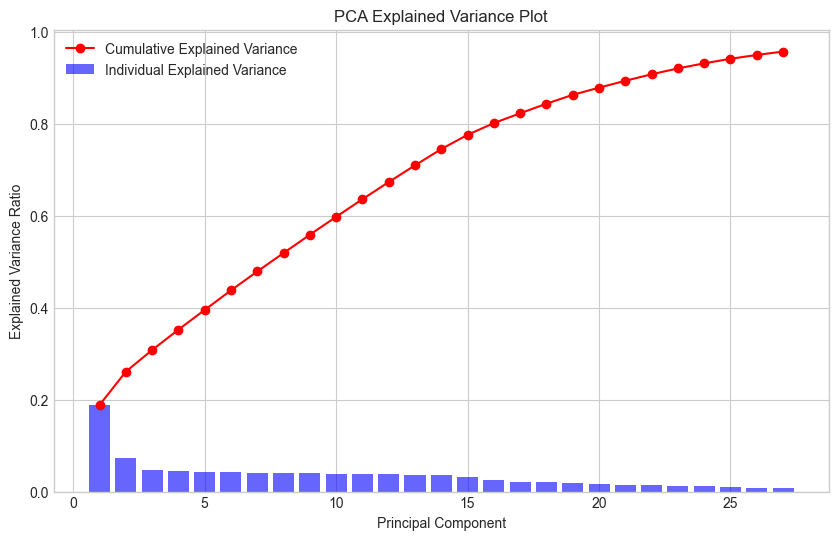

Number of PCA components: 27
Total explained variance: 0.9573


In [8]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
try:
    X_pca = pca.fit_transform(X_processed)
    print("X_pca shape after PCA (reduced dimensions):", X_pca.shape)
except Exception as e:
    print(f"Error in PCA transformation: {e}")
    raise

# Explained variance plot for PCA
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, color='b', label='Individual Explained Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', color='r', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Plot')
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of PCA components: {X_pca.shape[1]}")
print(f"Total explained variance: {cumulative_variance[-1]:.4f}")

In [9]:
# Train-test split (stratify for imbalance)
try:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42, stratify=y)
    print("X_train shape (after PCA):", X_train.shape)
    print("X_test shape (after PCA):", X_test.shape)
except Exception as e:
    print(f"Error in train-test split: {e}")
    raise

X_train shape (after PCA): (1029, 27)
X_test shape (after PCA): (441, 27)


In [10]:
# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
try:
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print("X_train_smote shape after SMOTE:", X_train_smote.shape)
    print(f"Balanced class distribution:\n{pd.Series(y_train_smote).value_counts()}")
except Exception as e:
    print(f"Error in SMOTE: {e}")
    raise

X_train_smote shape after SMOTE: (1726, 27)
Balanced class distribution:
Attrition
0    863
1    863
Name: count, dtype: int64


In [11]:
# Define function to fit ML algorithms with CV and additional metrics
def fit_ml_algo(algo, X_train, y_train, X_test, y_test, cv):
    try:
        model = algo.fit(X_train, y_train)
        acc = round(model.score(X_train, y_train) * 100, 2)
        acc_cv = round(cross_val_score(algo, X_train, y_train, cv=cv, scoring='accuracy').mean() * 100, 2)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        test_acc = round(metrics.accuracy_score(y_test, test_pred) * 100, 2)
        report = classification_report(y_test, test_pred, output_dict=True)
        precision_1 = round(report['1']['precision'], 2)
        recall_1 = round(report['1']['recall'], 2)
        f1_1 = round(report['1']['f1-score'], 2)
        auc_roc = None
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]
            auc_roc = round(auc(*roc_curve(y_test, y_prob)[:2]), 2)
        return model, train_pred, acc, acc_cv, test_pred, test_acc, precision_1, recall_1, f1_1, auc_roc
    except Exception as e:
        print(f"Error in fit_ml_algo for {algo}: {e}")
        raise

In [12]:
# Hyperparameter tuning for Random Forest
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
try:
    rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
    rf_grid.fit(X_train_smote, y_train_smote)
    best_rf = rf_grid.best_estimator_
    print("Best Random Forest params:", rf_grid.best_params_)
except Exception as e:
    print(f"Error in Random Forest tuning: {e}")
    raise

# Hyperparameter tuning for XGBoost
xgb_param_grid = {'n_estimators': [50, 100], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}
try:
    xgb_grid = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'), xgb_param_grid, cv=5)
    xgb_grid.fit(X_train_smote, y_train_smote)
    best_xgb = xgb_grid.best_estimator_
    print("Best XGBoost params:", xgb_grid.best_params_)
except Exception as e:
    print(f"Error in XGBoost tuning: {e}")
    raise

Best Random Forest params: {'max_depth': 20, 'n_estimators': 100}
Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [13]:
# List of models
models = {
    'Logistic Regression': LogisticRegression(penalty='l2', C=0.1, class_weight='balanced'),
    'Linear SVC': LinearSVC(penalty='l1', dual=False, C=0.1, class_weight='balanced', max_iter=10000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': best_rf,
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': best_xgb
}

# Dictionary to store results
results = {}
trained_models = {}

for name, algo in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    try:
        model, train_pred, acc, acc_cv, test_pred, test_acc, prec_1, rec_1, f1_1, auc_roc = fit_ml_algo(
            algo, X_train_smote, y_train_smote, X_test, y_test, 10
        )
        runtime = time.time() - start_time
        print(f"{name} Results:")
        print(f"Train Accuracy: {acc}%")
        print(f"CV 10-Fold Accuracy: {acc_cv}%")
        print(f"Test Accuracy: {test_acc}%")
        print(f"AUC-ROC: {auc_roc if auc_roc else 'N/A'}")
        print("Classification Report:\n", classification_report(y_test, test_pred))
        print(f"Running Time: {datetime.timedelta(seconds=runtime)}")

        # Save model
        model_filename = f'model_{name.lower().replace(" ", "_")}.pkl'
        joblib.dump(model, model_filename)
        print(f"{name} model saved as '{model_filename}'")

        trained_models[name] = model
        results[name] = {
            'train_acc': acc,
            'cv_acc': acc_cv,
            'test_acc': test_acc,
            'prec_1': prec_1,
            'rec_1': rec_1,
            'f1_1': f1_1,
            'auc_roc': auc_roc,
            'runtime': round(runtime, 2),
            'test_pred': test_pred,
            'model': model
        }
    except Exception as e:
        print(f"Error training {name}: {e}")
        raise

Training Logistic Regression...
Logistic Regression Results:
Train Accuracy: 80.13%
CV 10-Fold Accuracy: 79.78%
Test Accuracy: 77.55%
AUC-ROC: 0.8
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.80      0.86       370
           1       0.39      0.66      0.49        71

    accuracy                           0.78       441
   macro avg       0.66      0.73      0.67       441
weighted avg       0.84      0.78      0.80       441

Running Time: 0:00:00.263390
Logistic Regression model saved as 'model_logistic_regression.pkl'
Training Linear SVC...
Linear SVC Results:
Train Accuracy: 80.13%
CV 10-Fold Accuracy: 79.49%
Test Accuracy: 76.87%
AUC-ROC: N/A
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       370
           1       0.38      0.66      0.48        71

    accuracy                           0.77       441
   macro avg       0.65      0.73  

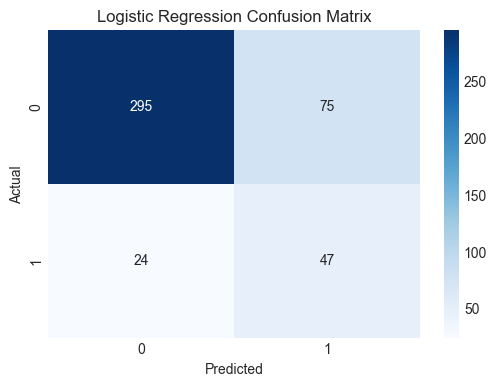

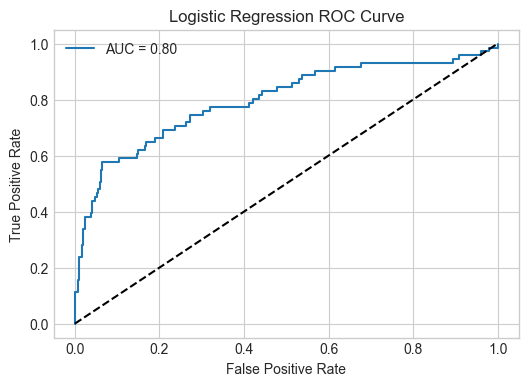

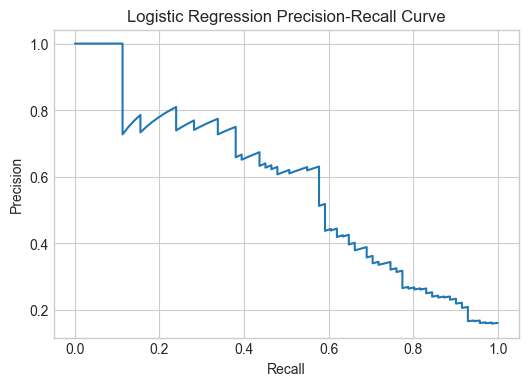

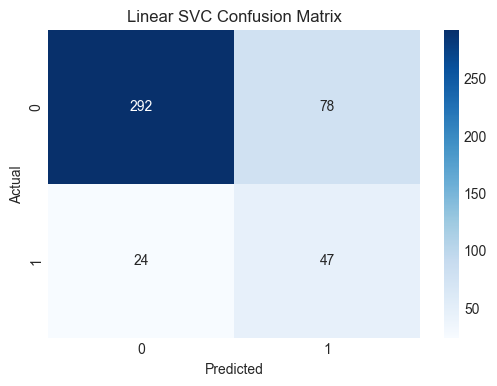

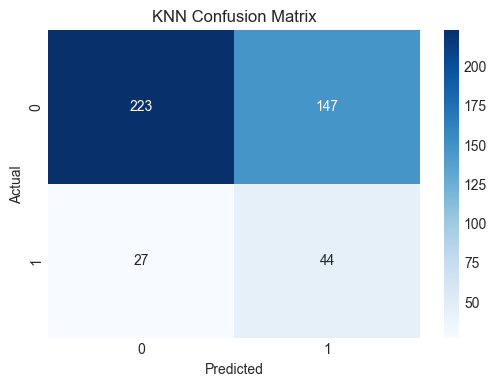

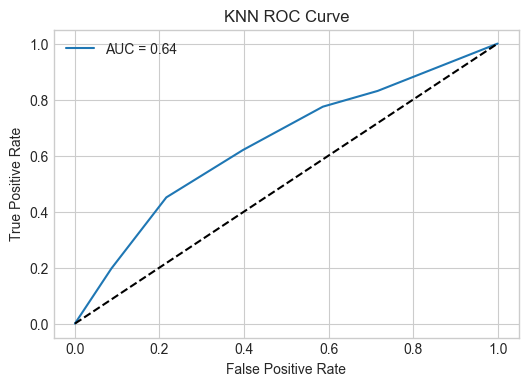

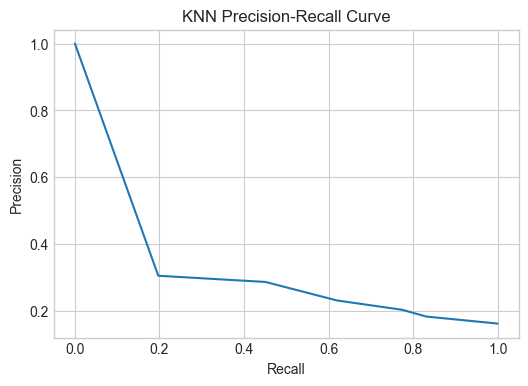

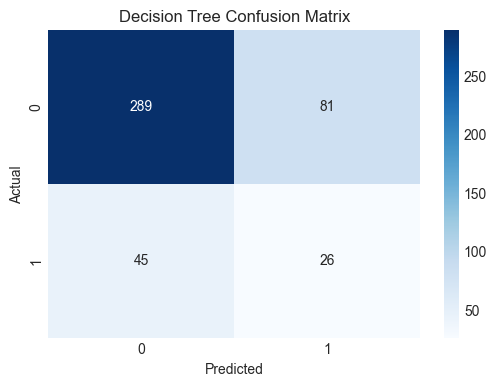

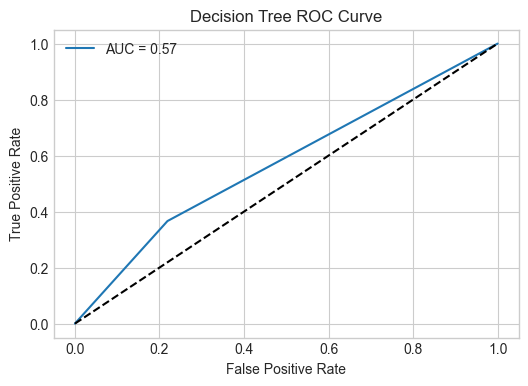

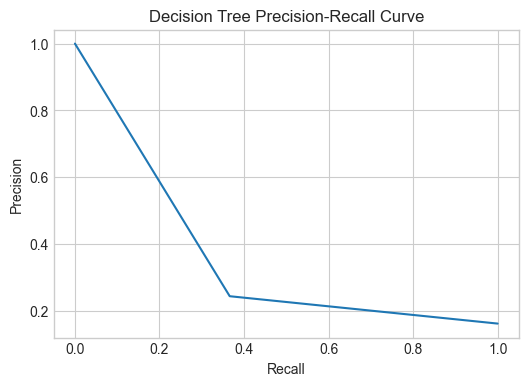

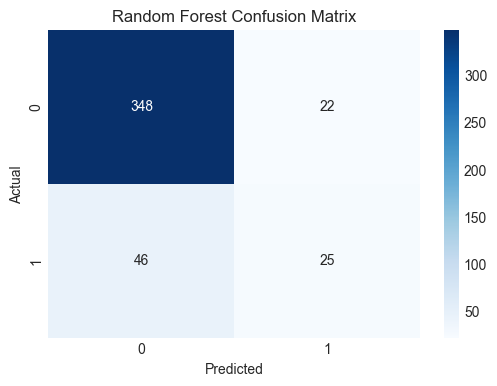

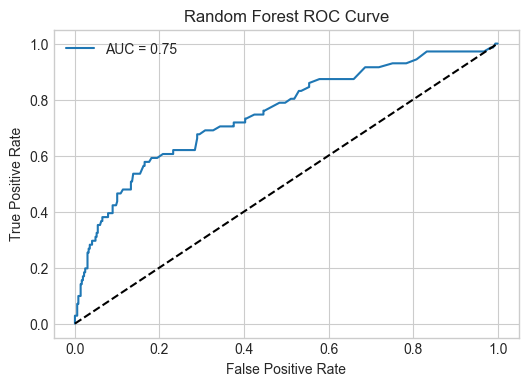

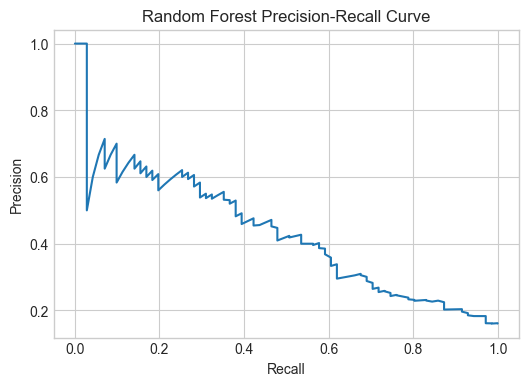

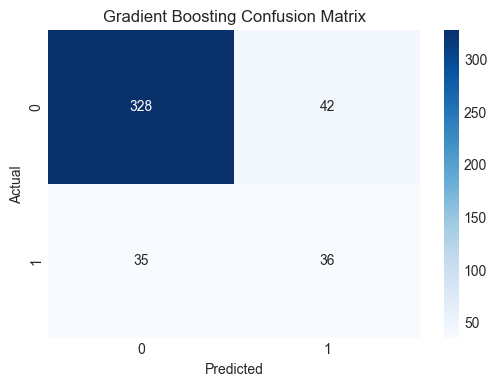

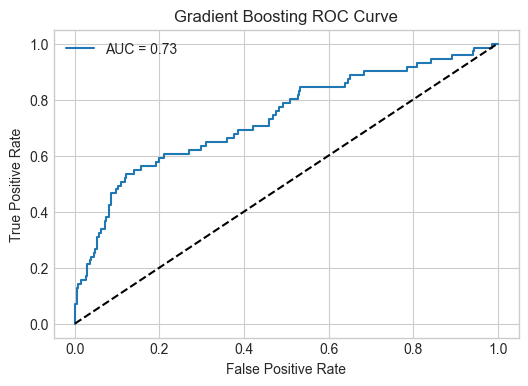

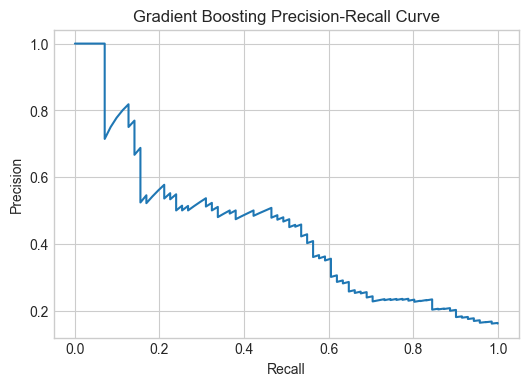

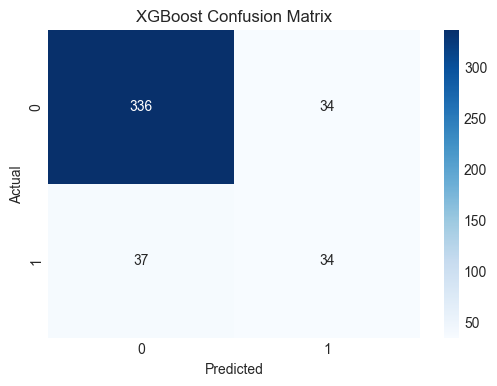

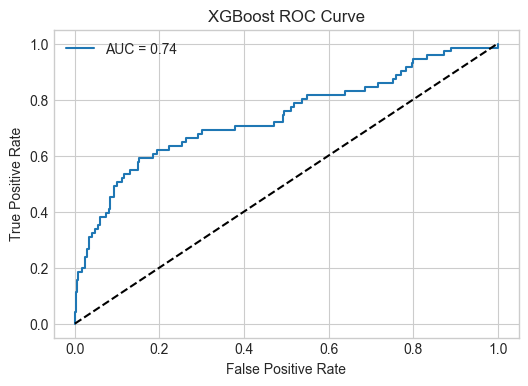

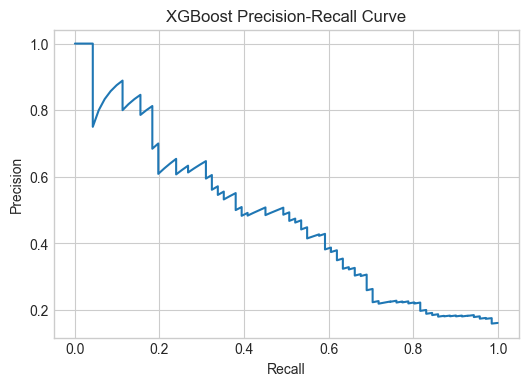

In [14]:
# Visuals for each model: Confusion Matrix, ROC, Precision-Recall
for name, res in results.items():
    test_pred = res['test_pred']
    model = res['model']
    
    # Confusion Matrix
    try:
        cm = confusion_matrix(y_test, test_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    except Exception as e:
        print(f"Error plotting confusion matrix for {name}: {e}")
    
    if hasattr(model, 'predict_proba'):
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            
            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f'AUC = {res["auc_roc"]:.2f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{name} ROC Curve')
            plt.legend()
            plt.show()
            
            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(y_test, y_prob)
            plt.figure(figsize=(6, 4))
            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'{name} Precision-Recall Curve')
            plt.show()
        except Exception as e:
            print(f"Error plotting curves for {name}: {e}")

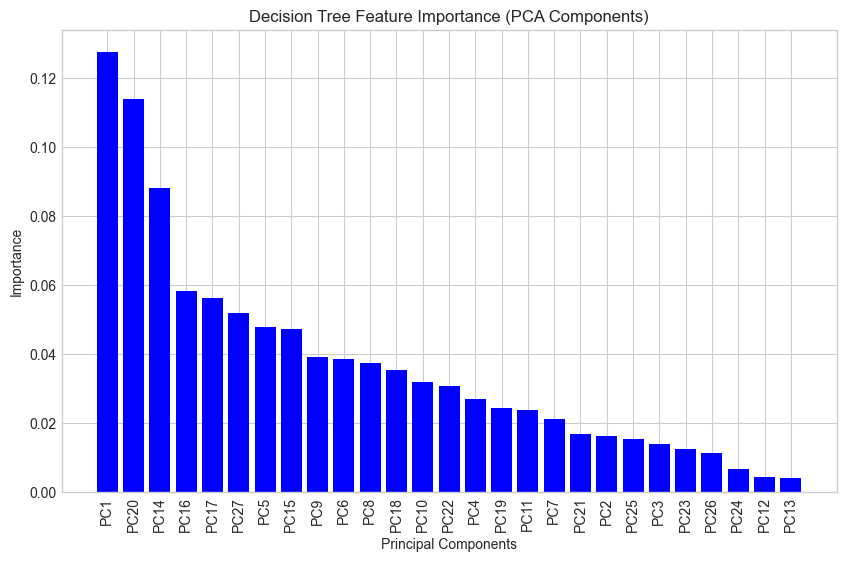

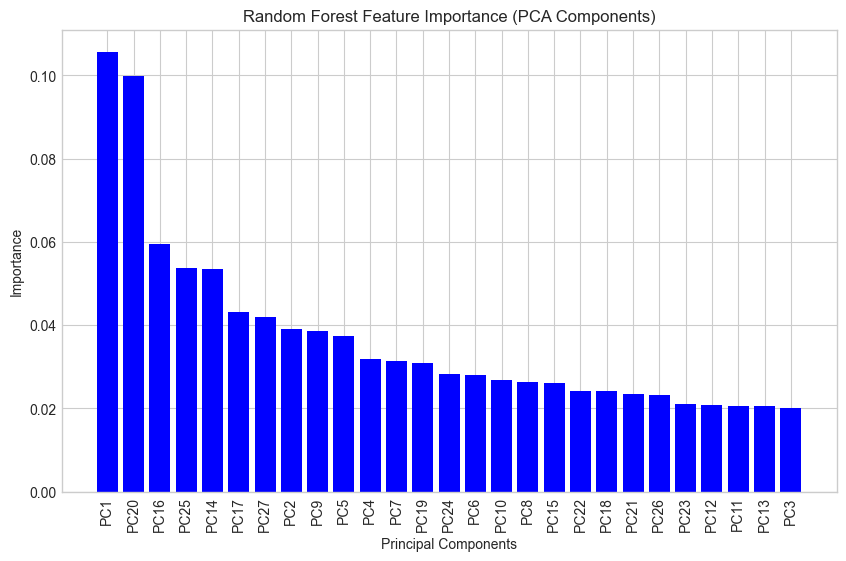

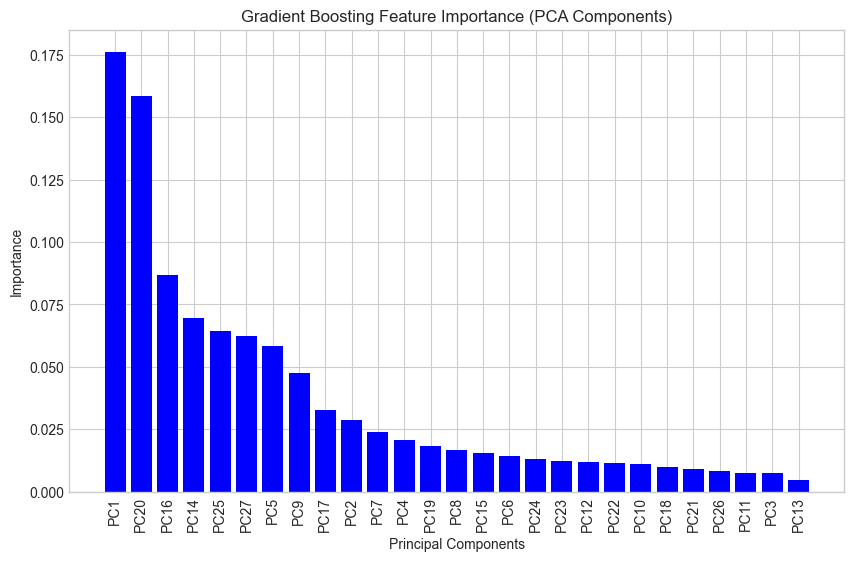

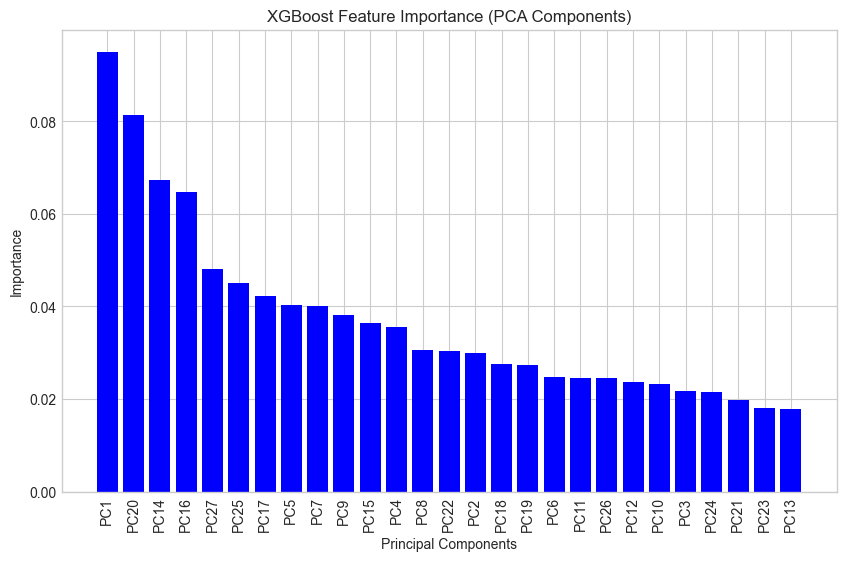

In [15]:
# Feature Importance for tree-based models
tree_models = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
for name in tree_models:
    if name in trained_models:
        model = trained_models[name]
        if hasattr(model, 'feature_importances_'):
            try:
                importances = model.feature_importances_
                indices = np.argsort(importances)[::-1]
                plt.figure(figsize=(10, 6))
                plt.bar(range(len(importances)), importances[indices], color='b')
                plt.xticks(range(len(importances)), [f'PC{i+1}' for i in indices], rotation=90)
                plt.title(f'{name} Feature Importance (PCA Components)')
                plt.xlabel('Principal Components')
                plt.ylabel('Importance')
                plt.show()
            except Exception as e:
                print(f"Error plotting feature importance for {name}: {e}")

In [16]:
# Model Comparison Table
try:
    comparison_data = {
        'Model': list(results.keys()),
        'Train Accuracy (%)': [res['train_acc'] for res in results.values()],
        'CV Accuracy (%)': [res['cv_acc'] for res in results.values()],
        'Test Accuracy (%)': [res['test_acc'] for res in results.values()],
        'Precision (Class 1)': [res['prec_1'] for res in results.values()],
        'Recall (Class 1)': [res['rec_1'] for res in results.values()],
        'F1-Score (Class 1)': [res['f1_1'] for res in results.values()],
        'AUC-ROC': [res['auc_roc'] if res['auc_roc'] else 'N/A' for res in results.values()],
        'Runtime (s)': [res['runtime'] for res in results.values()]
    }
    comparison_df = pd.DataFrame(comparison_data)
    print("\nModel Comparison Table:")
    display(comparison_df)
    comparison_df.to_excel("model_comparison.xlsx", index=False)
    print("Model comparison table saved as 'model_comparison.csv'")
except Exception as e:
    print(f"Error creating comparison table: {e}")
    raise


Model Comparison Table:


,Model,Train Accuracy (%),CV Accuracy (%),Test Accuracy (%),Precision (Class 1),Recall (Class 1),F1-Score (Class 1),AUC-ROC,Runtime (s)
0,Logistic Regression,80.13,79.78,77.55,0.39,0.66,0.49,0.8,0.26
1,Linear SVC,80.13,79.49,76.87,0.38,0.66,0.48,N/A,0.11
2,KNN,85.92,80.42,60.54,0.23,0.62,0.34,0.64,0.69
3,Decision Tree,100.00,83.55,71.43,0.24,0.37,0.29,0.57,0.83
4,Random Forest,100.00,94.61,84.58,0.53,0.35,0.42,0.75,12.27
5,Gradient Boosting,97.51,89.05,82.54,0.46,0.51,0.48,0.73,29.71
6,XGBoost,100.00,94.03,83.90,0.50,0.48,0.49,0.74,4.50


Model comparison table saved as 'model_comparison.csv'


In [17]:
# Save preprocessed data and preprocessing objects
try:
    np.save('X_pca.npy', X_pca)
    np.save('X_train_smote.npy', X_train_smote)
    np.save('y_train_smote.npy', y_train_smote)
    np.save('X_test.npy', X_test)
    np.save('y_test.npy', y_test)
    joblib.dump(preprocessor, 'preprocessor.pkl')
    joblib.dump(pca, 'pca.pkl')
    print("Preprocessed data, preprocessor, and PCA saved successfully as .npy and .pkl files")
except Exception as e:
    print(f"Error saving preprocessed data: {e}")
    raise

# Verify saved files
print("Files in current directory:")
for file in os.listdir('.'):
    if file.endswith(('.pkl', '.npy', '.csv')):
        print(f"✓ {file}")

Preprocessed data, preprocessor, and PCA saved successfully as .npy and .pkl files
Files in current directory:
✓ model_decision_tree.pkl
✓ model_gradient_boosting.pkl
✓ model_knn.pkl
✓ model_linear_svc.pkl
✓ model_logistic_regression.pkl
✓ model_random_forest.pkl
✓ model_xgboost.pkl
✓ pca.pkl
✓ preprocessor.pkl
✓ WA_Fn-UseC_-HR-Employee-Attrition.csv
✓ X_pca.npy
✓ X_test.npy
✓ X_train_smote.npy
✓ y_test.npy
✓ y_train_smote.npy


# Enhanced Notes:
# - Dataset: IBM HR Employee Attrition (1470 rows, 35 columns) from public URL.
# - Models: Logistic Regression, Linear SVC, KNN, Decision Tree, Random Forest, Gradient Boosting, XGBoost.
# - Features: PCA retains 95% variance; dropped irrelevant columns (EmployeeCount, StandardHours, etc.).
# - SMOTE: Balances training data for attrition (16% Yes).
# - Visuals: Confusion matrices, ROC curves, Precision-Recall curves, feature importance for tree models.
# - Hyperparameter Tuning: GridSearchCV for Random Forest and XGBoost.
# - Outputs: Models saved as .pkl, data as .npy, comparison table as .csv.
# - Focus on Recall and F1 for minority class (Attrition=Yes).
# - Run this notebook completely to generate all files needed for chatbot/Streamlit app.